<a href="https://colab.research.google.com/github/Weizhuo-Zhang/ML_coursera/blob/master/hands_on_ML/5_SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 五、支持向量机(Supported Vector Machine)

支持向量机（SVM）是个非常强大并且有多种功能的机器学习模型，能够做线性或者非线性的分类，回归，甚至异常值检测。机器学习领域中最为流行的模型之一，是任何学习机器学习的人必备的工具。SVM 特别适合应用于复杂但中小规模数据集的分类问题。

## 线性支持向量机分类

### 软间隔分类

In [1]:
import numpy as np
from sklearn import datasets
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

iris = datasets.load_iris()
X = iris["data"][:, (2,3)] # petal length, petal width
y = (iris["target"] == 2).astype(np.float64) # Iris-Virginica

svm_clf = Pipeline((
  ("scaler", StandardScaler()),
  ("linear_svc", LinearSVC(C=1, loss="hinge")),
))

svm_clf.fit(X, y)

print(svm_clf.predict([[5.5, 1.7]]))


[1.]


**注：**

不同于 Logistic 回归分类器，SVM 分类器不会输出每个类别的概率。

作为一种选择，你可以在 SVC 类，使用 `SVC(kernel="linear", C=1)` ，但是它比较慢，尤其在较大的训练集上，所以一般不被推荐。另一个选择是使用 `SGDClassifier` 类，即 `SGDClassifier(loss="hinge", alpha=1/(m*C))` 。它应用了随机梯度下降（SGD 见第四章）来训练一个线性 SVM 分类器。尽管它不会和 LinearSVC 一样快速收敛，但是对于处理那些不适合放在内存的大数据集是非常有用的，或者处理在线分类任务同样有用。

## 非线性支持向量机分类

In [2]:
from sklearn.datasets import make_moons
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

X, y = make_moons(noise=0.1)

polynomial_svm_clf = Pipeline((
  ("poly_features", PolynomialFeatures(degree=3)),
  ("scaler", StandardScaler()),
  ("svm_clf", LinearSVC(C=10, loss="hinge"))
))

clf = polynomial_svm_clf.fit(X, y)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


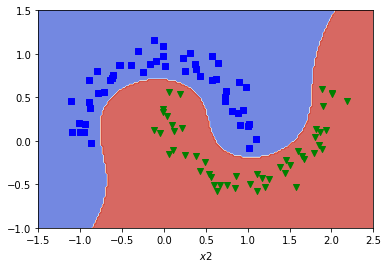

In [3]:
import matplotlib.pyplot as plt

def make_meshgrid(x, y, h=.02):
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy

def plot_contours(ax, clf, xx, yy, **params):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

def plot_decision_boundary(X, y, clf, ax):
  xx, yy = make_meshgrid(X,y)
  plot_contours(ax, clf, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)

def plot_moons_scatter(X, y, label_0, label_1):
  plt.scatter(X[label_0], y[label_0], c="b", marker="s")
  plt.scatter(X[label_1], y[label_1], c="g", marker="v")
  plt.xlim(-1.5, 2.5)
  plt.ylim(-1, 1.5)
  plt.xlabel("$x1$")
  plt.xlabel("$x2$")
  
label_0 = (y == 0)
label_1 = (y == 1)
X0, X1 = X[:, 0], X[:, 1]

fig, ax = plt.subplots()
plot_decision_boundary(X0, X1, polynomial_svm_clf, ax)
plot_moons_scatter(X0, X1, label_0, label_1)

plt.show()

### 多项式核

添加多项式特征很容易实现，不仅仅在 SVM，在各种机器学习算法都有不错的表现，但是低次数的多项式不能处理非常复杂的数据集，而高次数的多项式却产生了大量的特征，会使模型变得慢。

幸运的是，当你使用 SVM 时，你可以运用一个被称为“核巧”（kernel trick）的神奇数学技巧。它可以取得就像你添加了许多多项式，甚至有高次数的多项式，一样好的结果。所以不会大量特征导致的组合爆炸，因为你并没有增加任何特征。这个技巧可以用 SVC 类来实现。
让我们在卫星数据集测试一下效果。

In [0]:
def kernel_trick(X, y, degree, coef0, C):
  from sklearn.svm import SVC
  poly_kernel_svm_clf = Pipeline((
    ("scaler", StandardScaler()),
    ("svm_clf", SVC(kernel="poly", degree=degree, coef0=coef0, C=C))
  ))
  return poly_kernel_svm_clf.fit(X, y)

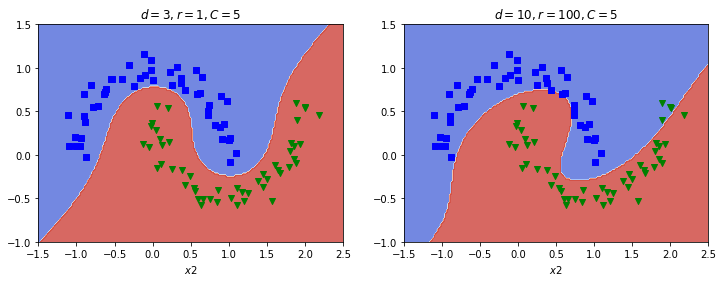

In [5]:
from sklearn.datasets import make_moons
X, y = make_moons(noise=0.1)

f, axs = plt.subplots(1,2,figsize=(12,4))
axs[0].axis('off')
ax = f.add_subplot(121)
degree, coef0, C = 3, 1, 5
plot_decision_boundary(X0, X1, kernel_trick(X, y, degree, coef0, C), ax)
plot_moons_scatter(X0, X1, label_0, label_1)
plt.title("$d={0}, r={1}, C={2}$".format(degree, coef0, C))

axs[1].axis('off')
ax = f.add_subplot(122)
degree, coef0, C = 10, 100, 5
plot_decision_boundary(X0, X1, kernel_trick(X, y, degree, coef0, C), ax)
plot_moons_scatter(X0, X1, label_0, label_1)
plt.title("$d={0}, r={1}, C={2}$".format(degree, coef0, C))

plt.show()

###  增加相似特征

### 高斯 RBF (Radial Basis Function) 核

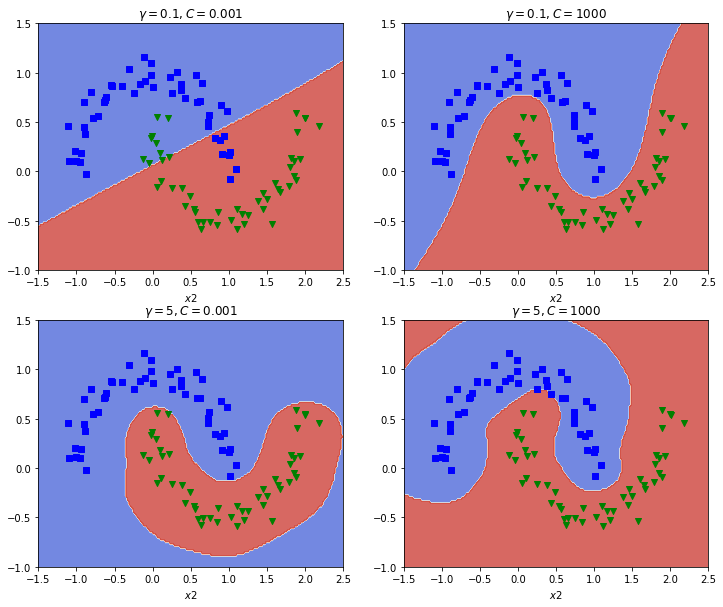

In [6]:
def rbf_kernel(X, y, gamma, C):
  from sklearn.svm import SVC
  rbf_kernel_svm_clf = Pipeline((
    ("scaler", StandardScaler()),
    ("svm_clf", SVC(kernel="rbf", gamma=gamma, C=C))
  ))
  return rbf_kernel_svm_clf.fit(X, y)

f, axs = plt.subplots(2,2,figsize=(12,10))
axs[0,0].axis('off')
ax = f.add_subplot(221)
gamma, C = 0.1, 0.001
plot_decision_boundary(X0, X1, rbf_kernel(X, y, gamma, C), ax)
plot_moons_scatter(X0, X1, label_0, label_1)
plt.title("$\gamma={0}, C={1}$".format(gamma, C))

axs[0,1].axis('off')
ax = f.add_subplot(222)
gamma, C = 0.1, 1000
plot_decision_boundary(X0, X1, rbf_kernel(X, y, gamma, C), ax)
plot_moons_scatter(X0, X1, label_0, label_1)
plt.title("$\gamma={0}, C={1}$".format(gamma, C))

axs[1,0].axis('off')
ax = f.add_subplot(223)
gamma, C = 5, 0.001
plot_decision_boundary(X0, X1, rbf_kernel(X, y, gamma, C), ax)
plot_moons_scatter(X0, X1, label_0, label_1)
plt.title("$\gamma={0}, C={1}$".format(gamma, C))

axs[1,1].axis('off')
ax = f.add_subplot(224)
gamma, C = 5, 1000
plot_decision_boundary(X0, X1, rbf_kernel(X, y, gamma, C), ax)
plot_moons_scatter(X0, X1, label_0, label_1)
plt.title("$\gamma={0}, C={1}$".format(gamma, C))

plt.show()

### 计算复杂性

`LinearSVC` 类基于 `liblinear` 库，它实现了线性 SVM 的优化算法。它并不支持核技巧(Kernel Trick)，但是它样本和特征的数量几乎是线性的：训练时间复杂度大约为 $O(m × n)$ 。

SVC 类基于 `libsvm` 库，它实现了支持核技巧的算法。训练时间复杂度通常介于$O(m^2 × n)$ 和 $O(m^3 × n)$ 之间。不幸的是，这意味着当训练样本变大时，它将变得极其慢（例如，成千上万个样本）。这个算法对于复杂但小型或中等数量的数据集表现是完美的。然而，它能对特征数量很好的缩放，尤其对稀疏特征来说（sparse features）（即每个样本都有一些非零特征）。

### SVM Regression 回归



In [7]:
from sklearn.svm import LinearSVR
svm_reg = LinearSVR(epsilon=1.5)
svm_reg.fit(X, y)

LinearSVR(C=1.0, dual=True, epsilon=1.5, fit_intercept=True,
          intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=1000,
          random_state=None, tol=0.0001, verbose=0)

In [8]:
from sklearn.svm import SVR
svm_poly_reg = SVR(kernel="poly", degree=2, C=100, epsilon=0.1)
svm_poly_reg.fit(X, y)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVR(C=100, cache_size=200, coef0=0.0, degree=2, epsilon=0.1,
    gamma='auto_deprecated', kernel='poly', max_iter=-1, shrinking=True,
    tol=0.001, verbose=False)

## 背后机制